In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score
from sklearn.preprocessing import label_binarize
import seaborn as sns
import os
import random
import time
import glob
from tqdm import tqdm

In [2]:
# Define the device 
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(device)

cuda


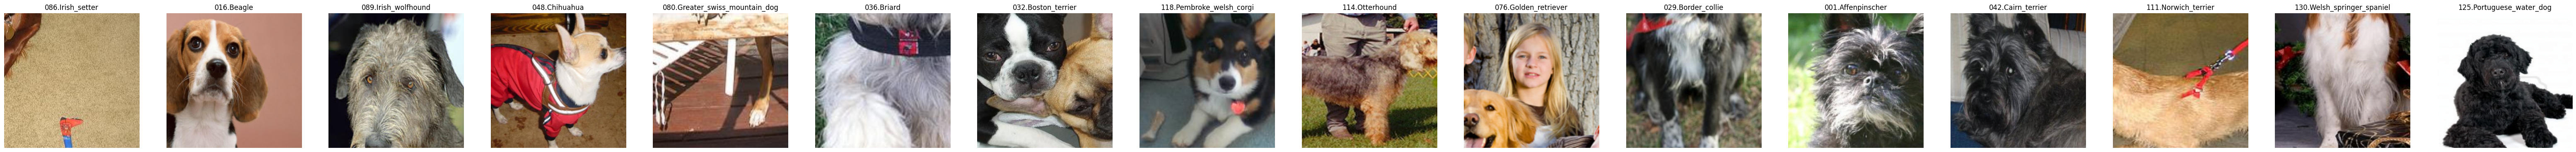

In [3]:
#set the batch size
batch_size = 16

#Data path
imagePath = '/home/melson/DeepL/dogImages'
#Data transformation

data_transforms_dict = {
    'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    
    'valid': transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    
    'test': transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    
    'prediction': transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
}

#load data
image_datasets = {x: datasets.ImageFolder(os.path.join(imagePath, x), data_transforms_dict[x]) 
                  for x in ['train', 'valid', 'test']}

#Dataloader
loaders_scratch = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
    for x in ['train', 'valid', 'test']
}

# Get a batch of training data
inputs, classes = next(iter(loaders_scratch['train']))
classes_names = image_datasets['train'].classes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}

num_images = len(inputs)  # 获取图像数量
fig, axes = plt.subplots(1, num_images, figsize=(num_images * 5, 5))  # 创建一个 subplot 行，每个图像一个 subplot

for i, (image, label) in enumerate(zip(inputs, classes)):
    image = image.to("cpu").clone().detach()  # 将图像移动到 CPU
    image = image.numpy().squeeze()  # 转换为 NumPy 数组并去掉不必要的维度
    image = image.transpose(1, 2, 0)  # 转置维度以适应 matplotlib 的显示格式
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))  # 反归一化
    image = image.clip(0, 1)  # 限制图像值在 0 到 1 之间

    ax = axes[i] if num_images > 1 else axes  # 获取当前 subplot 的轴对象
    ax.imshow(image)  # 在当前轴上显示图像
    ax.set_title(classes_names[label])  # 设置标题为类别名称
    ax.axis('off')  # 关闭坐标轴显示

plt.show()  # 显示整个图形


In [4]:
train_images = len(image_datasets['train'])
valid_images = len(image_datasets['valid'])
test_images = len(image_datasets['test'])

print("Number of images in train dataset:", train_images)
print("Number of images in valid dataset:", valid_images)
print("Number of images in test dataset:", test_images)

Number of images in train dataset: 16210
Number of images in valid dataset: 4600
Number of images in test dataset: 836


In [5]:
try:
    ImageFile.LOAD_TRUNCATED_IMAGES = True
except:
    pass


def train_model(n_epochs, loaders, model, optimizer, scheduler, criterion, device, save_path):

    scheduler = scheduler
    train_loss_history = []
    valid_loss_history = []
    train_acc_history = []
    valid_acc_history = []
    learning_rate_history = []

    best_acc = 0.0
    for epoch in range(1, n_epochs + 1):
        print('-' * 10)
        print(f'Epoch {epoch }/{n_epochs}')
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0

            #iterate over data
            for data, target in loaders[phase]:
                data, target = data.to(device), target.to(device)
                #zero the parameter gradients
                optimizer.zero_grad()

                #forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    output = model(data)
                    loss = criterion(output, target)
                    _, preds = torch.max(output, 1)
                    #backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                #statistics
                running_loss += loss.item() * data.size(0)
                running_corrects += torch.sum(preds == target.data)

            if phase == 'train':
                scheduler.step()
            # epoch_loss = np.mean(running_loss)
            # epoch_acc = np.mean(running_corrects)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_loss = epoch_loss
                train_acc = epoch_acc.cpu().numpy()
            else:
                valid_loss = epoch_loss
                valid_acc = epoch_acc.cpu().numpy()

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        print("Current learning rate; ", optimizer.param_groups[0]['lr'])

        
        #save the model if validation loss has decreased
        if phase == 'valid' and epoch_acc >= best_acc:
            best_acc = epoch_acc
            torch.save(model.state_dict(), save_path)
        
        
                    
        # Append histories after converting to normal Python types or ensuring they are on CPU
        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)
        train_acc_history.append(train_acc)
        valid_acc_history.append(valid_acc)
        learning_rate_history.append(optimizer.param_groups[0]['lr'])

    #save the model_metrics    
    model_metrics = {
        'train_loss_history': train_loss_history,
        'valid_loss_history': valid_loss_history,
        'train_acc_history': train_acc_history,
        'valid_acc_history': valid_acc_history,
        'learning_rate_history': learning_rate_history
    }
    return model, model_metrics

def plotting(input_metric, input_metric_name):
    
    
    fig, arg = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(input_metric_name, fontsize=16)
    # Plot for Learning Rate
    arg[0].plot(np.array(input_metric['learning_rate_history']), label='learning rate')
    arg[0].set_title('Learning Rate')
    arg[0].set_xlabel('Epoch')

    # Plot for loss
    arg[1].plot(np.array(input_metric['train_loss_history']), label='Training Loss')
    arg[1].plot(np.array(input_metric['valid_loss_history']), label='Validation Loss')
    arg[1].set_title('Loss')
    arg[1].set_xlabel('Epoch')
    arg[1].set_ylabel('loss')
    arg[1].legend()

    # Plot for accuracy
    arg[2].plot(np.array(input_metric['train_acc_history']), label='Training Accuracy')
    arg[2].plot(np.array(input_metric['valid_acc_history']), label='Validation Accuracy')
    arg[2].set_title('Accuracy')
    arg[2].set_xlabel('Epoch')
    arg[2].set_ylabel('acc')
    arg[2].legend()

    plt.show()

def load_model(model_path, model, device):
    """
    Load the trained model from a file.
    """
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    return model


def test_model(model_path, model, criterion, test_loader, device, show_images=False, images_per_figure=10):
    """
    Test the trained model with the provided test loader and optionally display images.
    Calculate accuracy, precision, recall, and mAP@50.
    """
    model = load_model(model_path, model, device)
    model.eval()  # Set model to evaluation mode
    
    test_loss = 0.0
    all_preds = []
    all_scores = []  # To store the softmax scores for mAP calculation
    all_targets = []
    class_names = classes_names

    # Initialize for image display
    if show_images:
        fig, axes = None, None
        current_image_count = 0

    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            # Forward pass
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item() * data.size(0)

            scores = torch.softmax(output, dim=1)  # Get the softmax scores
            _, preds = torch.max(output, 1)
            all_scores.extend(scores.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

            if show_images:
                # Image display logic
                if current_image_count % images_per_figure == 0:
                    if fig is not None:
                        plt.tight_layout()
                        plt.show()
                    num_images_remaining = len(test_loader.dataset) - current_image_count
                    cols = min(images_per_figure, num_images_remaining)
                    fig, axes = plt.subplots(nrows=1, ncols=cols, figsize=(cols * 2, 2))
                    if cols == 1:
                        axes = [axes]
                    
                ax = axes[current_image_count % images_per_figure]
                image = data.cpu().data[0].permute(1, 2, 0).numpy()
                image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                image = np.clip(image, 0, 1)
                ax.imshow(image)
                ax.set_title(f'Predicted: {class_names[preds[0]]}')
                ax.axis('off')
                current_image_count += 1

    if show_images and fig is not None:
        plt.tight_layout()
        plt.show()

    # Compute overall metrics
    test_loss /= len(test_loader.dataset)
    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, average='macro')
    recall = recall_score(all_targets, all_preds, average='macro')

    # Calculate mAP@50
    # Assuming binary classification for simplicity
    # You would need to adjust for multi-class/multi-label appropriately
    from sklearn.metrics import average_precision_score
    all_targets_onehot = label_binarize(all_targets, classes=np.unique(all_targets))
    map50 = average_precision_score(all_targets_onehot, np.array(all_scores), average='macro')

    test_metrics = {
        'test_loss': test_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'mAP@50': map50
    }

    return test_metrics

def plot_confusion_matrix(model_metric, class_names, model_name):
    """
    Plot the confusion matrix using seaborn and matplotlib.
    """
    plt.figure(figsize=(5, 4))
    sns.heatmap(model_metric['confusion_matrix'], annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('From %s (Acc: %.4f%%)' % (model_name, model_metric['accuracy']*100))
    plt.show()

In [17]:
class DogBreedResNet(nn.Module):
    def __init__(self, num_classes):
        super(DogBreedResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual blocks
        self.layer1 = self._make_layer(64, 64, 2)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)

        # Classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.downsample(x)

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        out = self.relu(out)

        return out

class DogBreedResNetFeatureExtractor(nn.Module):
    def __init__(self, pretrained_model):
        super(DogBreedResNetFeatureExtractor, self).__init__()
        # Keep all parts of the pretrained model except the final fully connected layer
        self.features = nn.Sequential(
            *list(pretrained_model.children())[:-1]  # Remove the last layer
        )
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  # Flatten the features into a vector
        return x
    


class HybridModel(nn.Module):
    def __init__(self, num_classes):
        super(HybridModel, self).__init__()
        self.dog_breed_resnet = DogBreedResNet(num_classes)
        

        self.resnet18 = models.resnet18(weights = models.ResNet18_Weights.DEFAULT)


        # Classifier to combine features
        # Assuming each network outputs 512 features
        # self.classifier = nn.Linear(133 + 133, num_classes)
        self.combined_features_size = 133 + 133  # Adjust accordingly if different
        self.classifier = nn.Sequential(
            nn.Linear(self.combined_features_size, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        features1 = self.dog_breed_resnet(x)
        features2 = self.resnet18(x)
        
        # Concatenate features along the feature dimension
        combined_features = torch.cat((features1, features2), dim=1)
        
        # Pass the combined features through the final classifier
        output = self.classifier(combined_features)
        return output
    
class ensemble_model(nn.Module):
    def __init__(self, model1, model2, model3):
        super().__init__()
        self.model1 = model1
        self.model2 = model2
        self.model3 = model3

        self.combined_features_size = 133 * 3

        self.classifier = nn.Sequential(
            nn.Linear(self.combined_features_size, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 133)
        )
    def forward(self, x):
        features1 = self.model1(x)
        features2 = self.model2(x)
        features3 = self.model3(x)
        
        # Concatenate features along the feature dimension
        combined_features = torch.cat((features1, features2, features3), dim=1)
        
        # Pass the combined features through the final classifier
        output = self.classifier(combined_features)
        return output

In [22]:
desnet = models.densenet201(weights=models.DenseNet201_Weights.DEFAULT)
for param in desnet.parameters():
    param.requires_grad = False
desnet.classifier = nn.Linear(desnet.classifier.in_features, out_features=133)
desnet.to(device)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(desnet.parameters(), lr = 0.001, weight_decay=1e-2, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

num_epoch = 50
# Train the model
print("Start Training model from scratch")
desnet, desnet_metric = train_model(num_epoch, loaders_scratch, desnet, optimizer, scheduler, criterion, device, '/home/melson/DeepL_Final/model_pt/desnet201_bs16.pt')


Start Training model from scratch
----------
Epoch 1/50
train Loss: 2.9913 Acc: 0.4508
valid Loss: 1.5867 Acc: 0.7122
Current learning rate;  0.001
----------
Epoch 2/50
train Loss: 1.7512 Acc: 0.6443
valid Loss: 1.2249 Acc: 0.7561
Current learning rate;  0.001
----------
Epoch 3/50
train Loss: 1.4230 Acc: 0.6901
valid Loss: 1.0546 Acc: 0.7661
Current learning rate;  0.001
----------
Epoch 4/50
train Loss: 1.3126 Acc: 0.7029
valid Loss: 1.0098 Acc: 0.7791
Current learning rate;  0.001
----------
Epoch 5/50
train Loss: 1.2288 Acc: 0.7248
valid Loss: 0.9857 Acc: 0.7857
Current learning rate;  0.001
----------
Epoch 6/50
train Loss: 1.1792 Acc: 0.7347
valid Loss: 0.9702 Acc: 0.7861
Current learning rate;  0.001
----------
Epoch 7/50
train Loss: 1.1573 Acc: 0.7371
valid Loss: 0.9516 Acc: 0.7824
Current learning rate;  0.001
----------
Epoch 8/50
train Loss: 1.1265 Acc: 0.7473
valid Loss: 0.9525 Acc: 0.7841
Current learning rate;  0.001
----------
Epoch 9/50
train Loss: 1.1213 Acc: 0.7492
v

In [12]:
desnet = models.densenet201()
for param in desnet.parameters():
    param.requires_grad = False
desnet.classifier = nn.Linear(desnet.classifier.in_features, out_features=133)
desnet.to(device)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
desnet_test = test_model('/home/melson/DeepL_Final/model_pt/desnet201_bs16.pt', desnet, criterion, loaders_scratch['test'], device, False)
print('test loss: %.3f' % desnet_test['test_loss'])
print('accuracy: %.3f%%' % (desnet_test['accuracy']*100))
print('recall: %.3f' % desnet_test['recall'])
print('precision: %.3f' % desnet_test['precision'])
print('mAP@50: %.3f' % desnet_test['mAP@50'])



test loss: 1.084
accuracy: 72.727%
recall: 0.701
precision: 0.734
mAP@50: 0.832


/home/melson/miniconda3/envs/melson/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
vgg19 = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
for param in vgg19.parameters():
    param.requires_grad = False
vgg19.classifier[6] = nn.Linear(vgg19.classifier[6].in_features, 133)
vgg19.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg19.parameters(), lr = 0.001, weight_decay=1e-2, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

num_epoch = 25
# Train the model
print("Start Training model from scratch")
vgg19, vgg19_metric = train_model(num_epoch, loaders_scratch, vgg19, optimizer, scheduler, criterion, device, '/home/melson/DeepL_Final/model_pt/vgg19_bs16.pt')


Start Training model from scratch
----------
Epoch 1/25
train Loss: 1.6285 Acc: 0.6212
valid Loss: 1.0511 Acc: 0.7387
Current learning rate;  0.001
----------
Epoch 2/25
train Loss: 1.0604 Acc: 0.7123
valid Loss: 0.9420 Acc: 0.7572
Current learning rate;  0.001
----------
Epoch 3/25
train Loss: 0.9815 Acc: 0.7303
valid Loss: 0.9123 Acc: 0.7602
Current learning rate;  0.001
----------
Epoch 4/25
train Loss: 0.9616 Acc: 0.7334
valid Loss: 0.8817 Acc: 0.7687
Current learning rate;  0.001
----------
Epoch 5/25
train Loss: 0.9392 Acc: 0.7383
valid Loss: 0.9188 Acc: 0.7472
Current learning rate;  0.0001
----------
Epoch 6/25
train Loss: 0.8905 Acc: 0.7494
valid Loss: 0.8723 Acc: 0.7665
Current learning rate;  0.0001
----------
Epoch 7/25
train Loss: 0.8782 Acc: 0.7546
valid Loss: 0.8733 Acc: 0.7643
Current learning rate;  0.0001
----------
Epoch 8/25
train Loss: 0.8703 Acc: 0.7598
valid Loss: 0.8589 Acc: 0.7730
Current learning rate;  0.0001
----------
Epoch 9/25
train Loss: 0.8621 Acc: 0.76

In [13]:
vgg19 = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
for param in vgg19.parameters():
    param.requires_grad = False
vgg19.classifier[6] = nn.Linear(vgg19.classifier[6].in_features, 133)
vgg19.to(device)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
vgg19_test = test_model('/home/melson/DeepL_Final/model_pt/vgg19_bs16.pt', vgg19, criterion, loaders_scratch['test'], device, False)
print('test loss: %.3f' % vgg19_test['test_loss'])
print('accuracy: %.3f%%' % (vgg19_test['accuracy']*100))
print('recall: %.3f' % vgg19_test['recall'])
print('precision: %.3f' % vgg19_test['precision'])
print('mAP@50: %.3f' % vgg19_test['mAP@50'])

test loss: 0.914
accuracy: 75.957%
recall: 0.747
precision: 0.789
mAP@50: 0.831


In [25]:
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
for param in resnet18.parameters():
    param.requires_grad = False
resnet18.fc = nn.Linear(resnet18.fc.in_features, 133)
resnet18.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr = 0.002, weight_decay=1e-2, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

num_epoch = 25
# Train the model
print("Start Training model from scratch")
resnet18, resnet18_metric = train_model(num_epoch, loaders_scratch, resnet18, optimizer, scheduler, criterion, device, '/home/melson/DeepL_Final/model_pt/resnet18_bs16.pt')



Start Training model from scratch
----------
Epoch 1/25
train Loss: 2.7743 Acc: 0.4136
valid Loss: 1.6856 Acc: 0.6174
Current learning rate;  0.002
----------
Epoch 2/25
train Loss: 1.8087 Acc: 0.5737
valid Loss: 1.3681 Acc: 0.6763
Current learning rate;  0.002
----------
Epoch 3/25
train Loss: 1.6035 Acc: 0.6102
valid Loss: 1.3490 Acc: 0.6696
Current learning rate;  0.002
----------
Epoch 4/25
train Loss: 1.5236 Acc: 0.6298
valid Loss: 1.2748 Acc: 0.6870
Current learning rate;  0.002
----------
Epoch 5/25
train Loss: 1.4833 Acc: 0.6394
valid Loss: 1.2482 Acc: 0.6996
Current learning rate;  0.0002
----------
Epoch 6/25
train Loss: 1.3999 Acc: 0.6724
valid Loss: 1.2460 Acc: 0.7002
Current learning rate;  0.0002
----------
Epoch 7/25
train Loss: 1.3831 Acc: 0.6809
valid Loss: 1.2369 Acc: 0.7011
Current learning rate;  0.0002
----------
Epoch 8/25
train Loss: 1.3890 Acc: 0.6832
valid Loss: 1.2388 Acc: 0.7052
Current learning rate;  0.0002
----------
Epoch 9/25
train Loss: 1.3932 Acc: 0.68

In [14]:
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
for param in resnet18.parameters():
    param.requires_grad = False
resnet18.fc = nn.Linear(resnet18.fc.in_features, 133)
resnet18.to(device)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
resnet18_test = test_model('/home/melson/DeepL_Final/model_pt/resnet18_bs16.pt', resnet18, criterion, loaders_scratch['test'], device, False)
print('test loss: %.3f' % resnet18_test['test_loss'])
print('accuracy: %.3f%%' % (resnet18_test['accuracy']*100))
print('recall: %.3f' % resnet18_test['recall'])
print('precision: %.3f' % resnet18_test['precision'])
print('mAP@50: %.3f' % resnet18_test['mAP@50'])

test loss: 1.308
accuracy: 65.311%
recall: 0.624
precision: 0.652
mAP@50: 0.777


/home/melson/miniconda3/envs/melson/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:

num_classes = 133
desnet = models.densenet201()
for param in desnet.parameters():
    param.requires_grad = False
desnet.classifier = nn.Linear(desnet.classifier.in_features, out_features=133)
desnet.to(device)
vgg19 = models.vgg19()
for param in vgg19.parameters():
    param.requires_grad = False
vgg19.classifier[6] = nn.Linear(vgg19.classifier[6].in_features, 133)
vgg19.to(device)
resnet18 = models.resnet18()
for param in resnet18.parameters():
    param.requires_grad = False
resnet18.fc = nn.Linear(resnet18.fc.in_features, 133)
resnet18.to(device)
desnet = load_model('/home/melson/DeepL_Final/model_pt/desnet201_bs16.pt', desnet, device)
vgg19 = load_model('/home/melson/DeepL_Final/model_pt/vgg19_bs16.pt', vgg19, device)
resnet18 = load_model('/home/melson/DeepL_Final/model_pt/resnet18_bs16.pt',resnet18, device)

ensemble_dawg = ensemble_model(desnet, vgg19, resnet18)
for param in ensemble_dawg.parameters():
    param.requires_grad = False

for param in ensemble_dawg.classifier.parameters():
    param.requires_grad = True

ensemble_dawg.to(device)


ensemble_model(
  (model1): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, moment

In [27]:
# Assuming you have some dummy input data `dummy_input` of the correct size
dummy_input = torch.randn(1, 3, 224, 224).to(device)  # Example size for a typical image input

ensemble_dawg.model1.eval()
ensemble_dawg.model2.eval()
ensemble_dawg.model3.eval()
ensemble_dawg.eval()

# Pass the dummy input through each model
output1 = ensemble_dawg.model1(dummy_input)
output2 = ensemble_dawg.model2(dummy_input)
output3 = ensemble_dawg.model3(dummy_input)
output = ensemble_dawg(dummy_input)

print("Output shape from model1:", output1.shape)
print("Output shape from model2:", output2.shape)
print("Output shape from model2:", output3.shape)
print("Output shape from model2:", output.shape)

Output shape from model1: torch.Size([1, 133])
Output shape from model2: torch.Size([1, 133])
Output shape from model2: torch.Size([1, 133])
Output shape from model2: torch.Size([1, 133])


In [17]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ensemble_dawg.parameters(), lr = 0.001, weight_decay=1e-2, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

num_epoch = 50
# Train the model
print("Start Training model from scratch")
model_scratch, metric_scratch = train_model(num_epoch, loaders_scratch, ensemble_dawg, optimizer, scheduler, criterion, device, '/home/melson/DeepL_Final/model_pt/ensemble_model_bs16.pt')


Start Training model from scratch
----------
Epoch 1/50
train Loss: 1.8231 Acc: 0.5569
valid Loss: 1.0273 Acc: 0.7346
Current learning rate;  0.001
----------
Epoch 2/50
train Loss: 1.1239 Acc: 0.6864
valid Loss: 0.9085 Acc: 0.7546
Current learning rate;  0.001
----------
Epoch 3/50
train Loss: 1.0468 Acc: 0.7065
valid Loss: 0.8552 Acc: 0.7730
Current learning rate;  0.001
----------
Epoch 4/50
train Loss: 1.0198 Acc: 0.7138
valid Loss: 0.8646 Acc: 0.7670
Current learning rate;  0.001
----------
Epoch 5/50
train Loss: 0.9606 Acc: 0.7273
valid Loss: 0.8384 Acc: 0.7717
Current learning rate;  0.0005
----------
Epoch 6/50
train Loss: 0.9289 Acc: 0.7424
valid Loss: 0.8283 Acc: 0.7837
Current learning rate;  0.0005
----------
Epoch 7/50
train Loss: 0.9193 Acc: 0.7458
valid Loss: 0.8341 Acc: 0.7824
Current learning rate;  0.0005
----------
Epoch 8/50
train Loss: 0.9225 Acc: 0.7439
valid Loss: 0.8229 Acc: 0.7763
Current learning rate;  0.0005
----------
Epoch 9/50
train Loss: 0.9082 Acc: 0.74

In [18]:
ensemble_dawg = ensemble_model(desnet, vgg19, resnet18)
for param in ensemble_dawg.parameters():
    param.requires_grad = False

for param in ensemble_dawg.classifier.parameters():
    param.requires_grad = True
ensemble_dawg.to(device)
ensemble_dawg_test = test_model('/home/melson/DeepL_Final/model_pt/ensemble_model_bs16.pt', ensemble_dawg, criterion, loaders_scratch['test'], device, False)
print('test loss: %.3f' % ensemble_dawg_test['test_loss'])
print('accuracy: %.3f%%' % (ensemble_dawg_test['accuracy']*100))
print('recall: %.3f' % ensemble_dawg_test['recall'])
print('precision: %.3f' % ensemble_dawg_test['precision'])
print('mAP@50: %.3f' % ensemble_dawg_test['mAP@50'])

test loss: 0.832
accuracy: 77.512%
recall: 0.760
precision: 0.793
mAP@50: 0.861


/home/melson/miniconda3/envs/melson/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
